## **0. Download dataset**

In [ ]:
# https://drive.google.com/file/d/1BENHjw8U6sj2IjXvYEvltQ_jaWg0zKcw/view
!gdown 1BENHjw8U6sj2IjXvYEvltQ_jaWg0zKcw
!unzip -q img_cls_scenes_classification.zip

Downloading...
From (original): https://drive.google.com/uc?id=1BENHjw8U6sj2IjXvYEvltQ_jaWg0zKcw
From (redirected): https://drive.google.com/uc?id=1BENHjw8U6sj2IjXvYEvltQ_jaWg0zKcw&confirm=t&uuid=9433dbb4-a0c0-49fa-8d45-8c30391ca064
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:04<00:00, 62.6MB/s]


## **1. Import libraries**

In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
def set_seed(seed=59):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)
print(f"Using seed {seed}")

Using seed 59


## **2. Dataset structure and locations**

In [ ]:
root_dir = Path('scenes_classification')
train_dir = root_dir / 'train'
val_dir = root_dir / 'val'

classes = {
    label_idx: class_name
    for label_idx, class_name in enumerate(sorted(os.listdir(train_dir)))
}

X_train, y_train = [], []
X_test, y_test = [], []

for dataset_path in [train_dir, val_dir]:
    for label_idx, class_name in classes.items():
        class_dir = dataset_path / class_name
        if not class_dir.exists():
            continue
        for img_filename in sorted(class_dir.iterdir()):
            if not img_filename.is_file():
                continue
            img_path = str(img_filename)
            if 'train' in str(dataset_path):
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

print('Train images:', len(X_train))
print('Validation/Test candidates (from val folder):', len(X_test))

Train images: 14034
Validation/Test candidates (from val folder): 3000


## **3. Train, val split**

In [ ]:
seed = 0
val_size = 0.2
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
print('Split result:', len(X_train), 'train samples and', len(X_val), 'validation samples')

Split result: 11227 train samples and 2807 validation samples


## **4. Create dataloader**

In [ ]:
class ScenesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    tensor_img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = tensor_img / 255.0
    return normalized_img

In [ ]:
train_dataset = ScenesDataset(X_train, y_train, transform=transform)
val_dataset = ScenesDataset(X_val, y_val, transform=transform)
test_dataset = ScenesDataset(X_test, y_test, transform=transform)

train_batch_size = 128
test_batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

## **5. Create model**

In [ ]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = ***Your Code Here***
        x = self.bn1(x)
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        return torch.cat([res, x], 1)


class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                transitions = nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2),
                )
                self.dense_blocks.append(transitions)
                in_channels = out_channels
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        for block in self.dense_blocks:
            x = block(x)
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = ***Your Code Here***
        x = x.view(x.size(0), -1)
        return ***Your Code Here***

n_classes = len(classes)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DenseNet([6, 12, 24, 16], growth_rate=32, num_classes=n_classes).to(device)
print(model)

DenseNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dense_blocks): ModuleList(
    (0): DenseBlock(
      (block): Sequential(
        (0): BottleneckBlock(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (relu): ReLU()
        )
        (1): BottleneckBlock(
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)


## **6. Training**

In [ ]:
lr = 1e-2
epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    dataset_size = len(loader.dataset)
    avg_loss = total_loss / dataset_size if dataset_size else 0.0
    accuracy = correct / dataset_size if dataset_size else 0.0
    return avg_loss, accuracy

def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")
        for imgs, labels in train_pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())
            train_pbar.set_postfix({'loss': loss.item()})
        epoch_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(epoch_loss)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch + 1}/{epochs} - train loss: {epoch_loss:.4f} - val loss: {val_loss:.4f} - val acc: {val_acc:.4f}')
    return train_losses, val_losses

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
)

val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print('Evaluation on val / test dataset')
print('Val accuracy:', val_acc)
print('Test accuracy:', test_acc)

Epoch 1/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, loss=1.43]


Epoch 1/25 - train loss: 1.5569 - val loss: 1.4130 - val acc: 0.4916


Epoch 2/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=1.27]


Epoch 2/25 - train loss: 1.3430 - val loss: 1.2876 - val acc: 0.5351


Epoch 3/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.01it/s, loss=1.21]


Epoch 3/25 - train loss: 1.2513 - val loss: 1.2193 - val acc: 0.5540


Epoch 4/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=1.21]


Epoch 4/25 - train loss: 1.1970 - val loss: 1.1714 - val acc: 0.5704


Epoch 5/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=1.01]


Epoch 5/25 - train loss: 1.1536 - val loss: 1.1437 - val acc: 0.5750


Epoch 6/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, loss=1.02]


Epoch 6/25 - train loss: 1.1233 - val loss: 1.1127 - val acc: 0.5846


Epoch 7/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.01s/it, loss=1.22]


Epoch 7/25 - train loss: 1.0942 - val loss: 1.0802 - val acc: 0.6003


Epoch 8/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.971]


Epoch 8/25 - train loss: 1.0691 - val loss: 1.0553 - val acc: 0.6113


Epoch 9/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.01it/s, loss=1.08]


Epoch 9/25 - train loss: 1.0449 - val loss: 1.0356 - val acc: 0.6227


Epoch 10/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=1.11]


Epoch 10/25 - train loss: 1.0151 - val loss: 1.0052 - val acc: 0.6388


Epoch 11/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.916]


Epoch 11/25 - train loss: 0.9883 - val loss: 0.9812 - val acc: 0.6391


Epoch 12/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.924]


Epoch 12/25 - train loss: 0.9627 - val loss: 0.9631 - val acc: 0.6512


Epoch 13/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.897]


Epoch 13/25 - train loss: 0.9367 - val loss: 0.9325 - val acc: 0.6584


Epoch 14/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.01it/s, loss=0.898]


Epoch 14/25 - train loss: 0.9088 - val loss: 0.9155 - val acc: 0.6623


Epoch 15/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.82]


Epoch 15/25 - train loss: 0.8859 - val loss: 0.8974 - val acc: 0.6708


Epoch 16/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.887]


Epoch 16/25 - train loss: 0.8645 - val loss: 0.8748 - val acc: 0.6801


Epoch 17/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, loss=0.733]


Epoch 17/25 - train loss: 0.8402 - val loss: 0.8548 - val acc: 0.6829


Epoch 18/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, loss=0.75]


Epoch 18/25 - train loss: 0.8220 - val loss: 0.8471 - val acc: 0.6890


Epoch 19/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.776]


Epoch 19/25 - train loss: 0.8005 - val loss: 0.8296 - val acc: 0.6958


Epoch 20/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.789]


Epoch 20/25 - train loss: 0.7859 - val loss: 0.8117 - val acc: 0.7047


Epoch 21/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, loss=0.839]


Epoch 21/25 - train loss: 0.7669 - val loss: 0.7984 - val acc: 0.7036


Epoch 22/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.01it/s, loss=0.757]


Epoch 22/25 - train loss: 0.7463 - val loss: 0.7836 - val acc: 0.7114


Epoch 23/25 - Training: 100%|██████████| 88/88 [01:28<00:00,  1.00s/it, loss=0.769]


Epoch 23/25 - train loss: 0.7331 - val loss: 0.7790 - val acc: 0.7164


Epoch 24/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.803]


Epoch 24/25 - train loss: 0.7151 - val loss: 0.7685 - val acc: 0.7171


Epoch 25/25 - Training: 100%|██████████| 88/88 [01:27<00:00,  1.00it/s, loss=0.67]


Epoch 25/25 - train loss: 0.6973 - val loss: 0.7491 - val acc: 0.7325
Evaluation on val / test dataset
Val accuracy: 0.7324545778411115
Test accuracy: 0.7323333333333333


## Training Loss Visualization

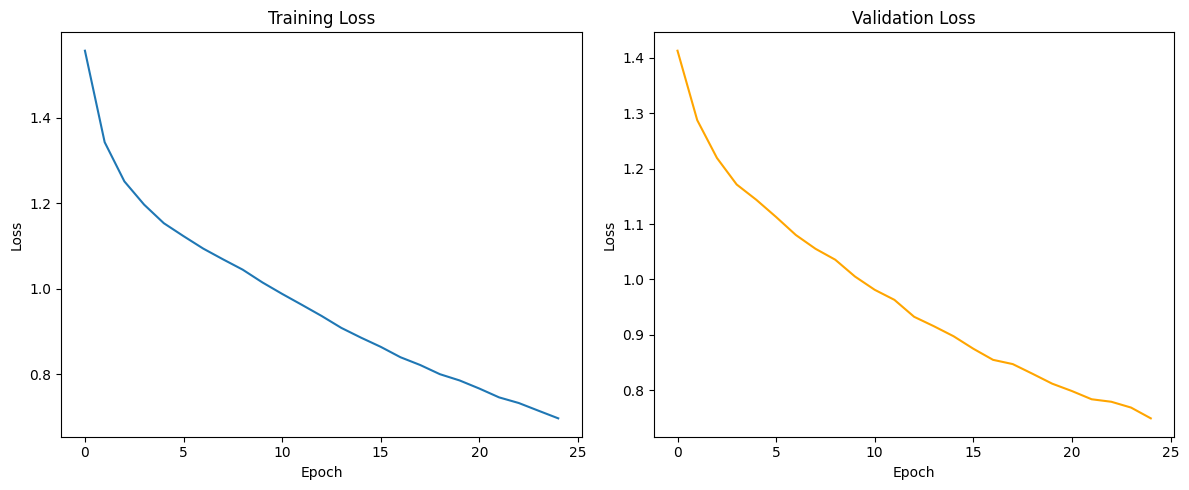

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.tight_layout()
plt.show()

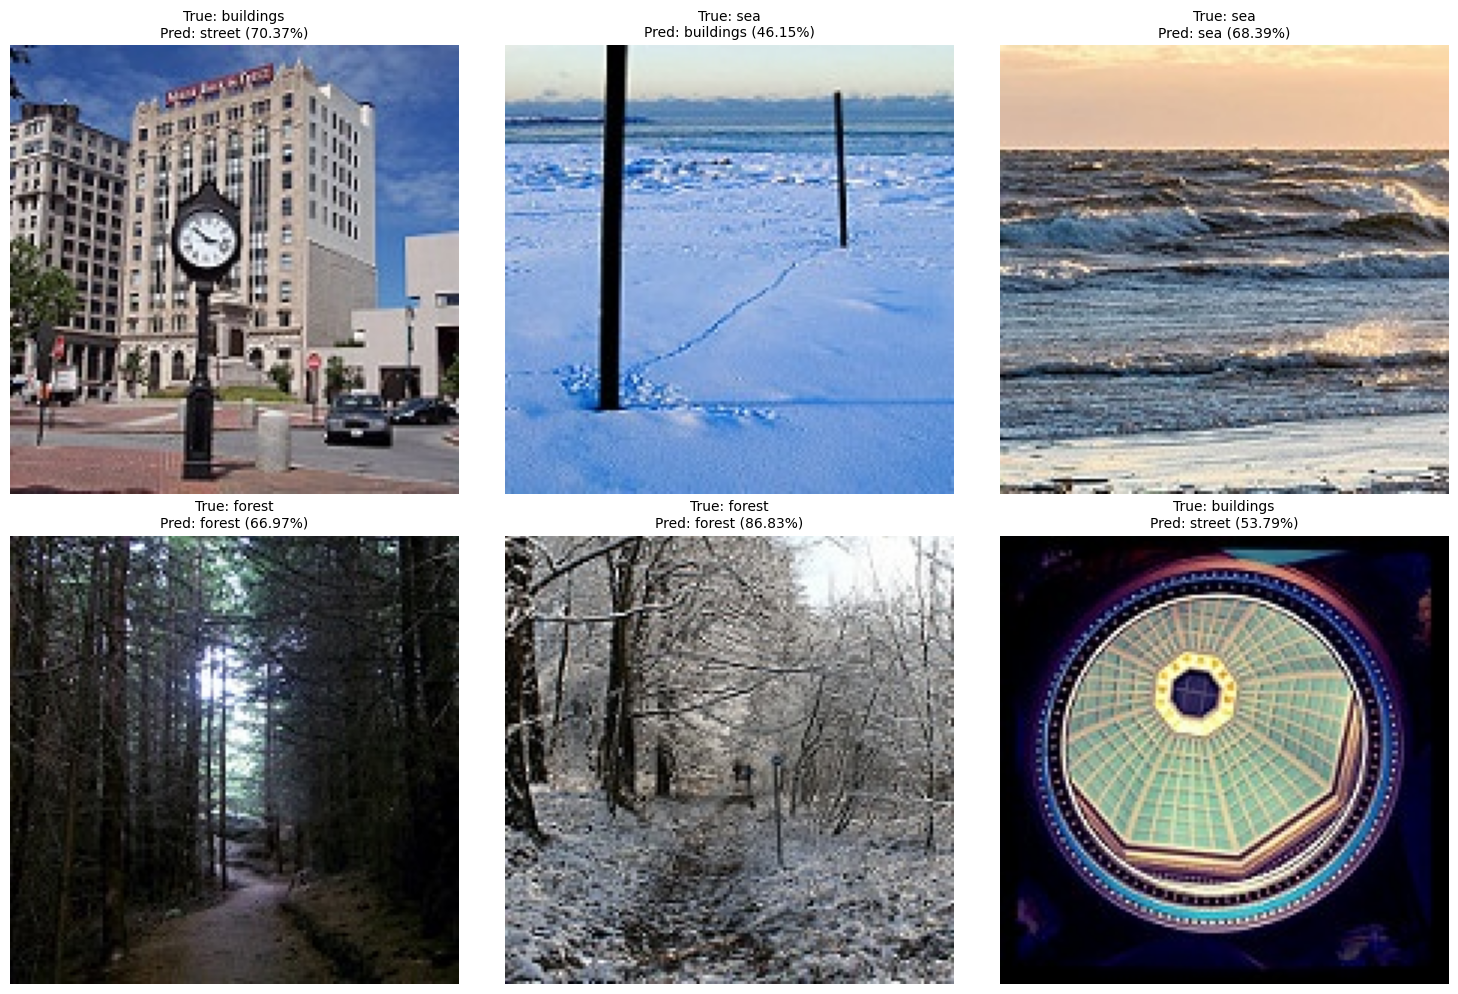

In [ ]:
def predict_sample(model, img_path, transform, device, classes):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        pred_prob = probs[0, pred_class].item()
    return classes[pred_class], pred_prob, img, probs[0].cpu().numpy()

# Test inference on random samples from test set
num_samples = 6
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_indices = np.random.choice(len(X_test), num_samples, replace=False)
for idx, sample_idx in enumerate(sample_indices):
    img_path = X_test[sample_idx]
    true_label = classes[y_test[sample_idx]]

    pred_class, pred_prob, img, probs = predict_sample(model, img_path, transform, device, classes)

    axes[idx].imshow(img)
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_class} ({pred_prob:.2%})', fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()